# Timeseries Testing and Modeling

_Jorge III Altamirano-Astorga, Ita-Andehui Santiago, Luz Aurora Hernández._

_Prof.: Edgar Francisco Román-Rangel._

In [ ]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
  SimpleRNN, Input, Conv1D, Flatten, Reshape, Permute, multiply, \
  GlobalAveragePooling1D, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf.get_logger().setLevel('ERROR')

BATCH_SIZE=256

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    ;
    
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Performance Plots for Model."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

def train_model(model, train_data,  validation_data,
                epochs=10, batch_size=BATCH_SIZE, 
                steps_per_epoch=100, loss='mse', optimizer='adam', 
                metrics=['mse'], verbose=0, base_dir=""):
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  display(plot_model(model, to_file=os.path.join(base_url, 
                                                         f"data/{model.name}.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True))
  cbk = TqdmCallback()
  tiempo = time.time()
  history = model.fit(train_data, validation_data=validation_data,
                      epochs=epochs, steps_per_epoch=steps_per_epoch, 
                      batch_size=BATCH_SIZE, verbose=verbose, callbacks=[cbk])
  clear_output()
  tiempo = time.time() - tiempo
  print(f"Processing Time: {tiempo:.2f} seconds.")

  #### Start Section: Save the Model
  base_dir = os.path.join(base_url, "models-paper", model.name)
  model.save(f"{base_dir}.h5")
  dill.dump(tiempo, open(f"{base_dir}.time.dill", 'wb'))
  dill.dump(history.history, open(f"{base_dir}.hist.dill", 'wb'))
  #### End Section: Save the Model
  return history
  
#render_mpl_table(df.head().applymap(shorten), col_width=5)
#sinaica = pd.read_pickle(uploaded)
#airdata = pd.read_pickle(os.path.join(base_url, "data/air-imputated.pickle.gz"))
data =  pd.read_pickle(os.path.join(base_url, "data/data_5min.pickle.gz"))
data = data[~data.isna().any(axis=1)]
data.head(2)

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,NO,CO,NO2,NOx,O3,PM10,PM2.5,SO2,temperature_outdoor,feels_like,pressure_outdoor,humidity_outdoor,wind_speed,wind_deg
datetime,,,,,,,,,,,,,,,,,,,,
2021-02-12 06:00:00,21.530000,777.410000,43.974000,151849.400000,37.200000,1.0,0.205071,2.200547,0.031007,0.206996,0.002,45.021898,22.005474,0.004002,14.928066,13.597920,1020.998175,43.001825,2.565310,109.799270
2021-02-12 06:05:00,21.689773,777.389432,43.361477,150039.409091,51.973864,1.0,0.206726,2.213276,0.031177,0.206911,0.002,45.531022,22.132755,0.004044,14.883093,13.549553,1020.955748,43.044252,2.456273,105.132299


## Timeseries

We use the the ```timeseries_dataset_from_array``` function from Keras Timeseries modeling functions. This function creates dataframes with sliding windows over time as an array.

This function work as follow:

```
tf.keras.utils.timeseries_dataset_from_array(
    X, Y,              # our dataset
    sequence_length,   #  Length of the output sequences (in number of timesteps): we need to text different sliding lengths to see how to get the best results on Deep Learning and not extending the processing time too much
    sequence_stride=1, # 1 is the default value for s, data[i], data[i + s], data[i + 2 * s]
    sampling_rate=1,   # 1 is the default value for timesteps data[i], data[i + r], ... data[i + sequence_length]
    shuffle=False,     # shuffle the records sorting, we set it in the default false value as the original order is relevant for timeseries 
    seed=None,         # we set a fixed seed to have repeatable experiments
    #...
)
```

On our research it is relevant to have an adequate sequence length. Then we can focus a brief research on empiric good times. Our proposal are:

### 1 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have  2880 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 10,080 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 21600 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 1 ~min$

### 2 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have 1,440 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 5040 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 10,080 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 2 ~min$

### 5 Minute Resampling

* 2 days before: i.e. on our resampling for every 5 min we'd have  576 records. This is because 
$2 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$
* 7 days before: i.e. on our resampling for every 5 min we'd have 2016 records. This is because 
$7 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$
* 15 days before: i.e. on our resampling for every 5 min we'd have 4320 records. This is because 
$15 ~days \times 24 ~hours \times 60 ~min \div 5 ~min$

We set this the number of days in a variable we set as **```WINDOW_SIZE_DAYS```**

## 5 Minute Resampling and 7 Days of History.

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dense(units=1, activation=None, name="output"))

trained_model01a = train_model(model_best01a, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae"],
                            epochs=100, steps_per_epoch=10, 
                            batch_size=BATCH_SIZE, base_dir=base_url)

Processing Time: 142.85 seconds.


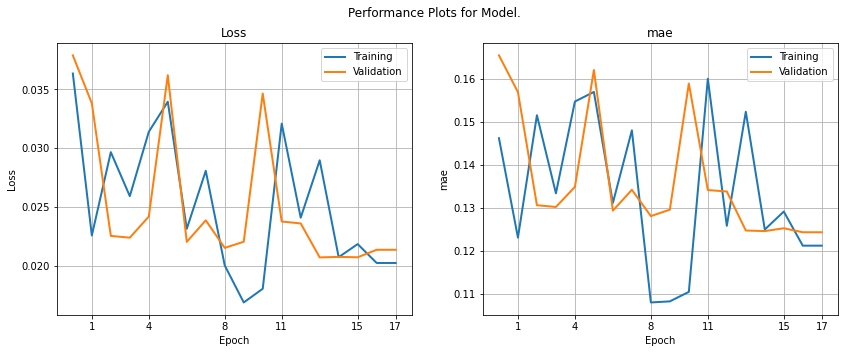

In [ ]:
performance_plot(trained_model01a.history, metrics=['mae'])

In [ ]:
# Inverse Transform of MinMaxScaler expects
# a shape (1, 17), we are going to do that
b = np.zeros((1, 17))
# We set the mean scaled IAQ of the last epoch 
# on the 5th column
b[0,4] = trained_model01a.history["val_mae"][-1]
## 
c = scaler_f.inverse_transform(b)
display(Markdown(f"* Mean Absolute Error in Real Scale of the last Epoch: \
**{c[0, 4]:.4f} IAQ points**."))

* Mean Absolute Error in Real Scale of the last Epoch: **61.6208 IAQ points**.

## 5 Minute Resampling and 2 Days of History with 2 Sampling Rate.

On our previous examples this quickly becomes unmanageable the we propose skipping some records and getting the previous hour by setting the ```sampling_rate``` parameter of 10 minute.


In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
sampling_rate = 2
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best01a = Sequential(name="model_best01a")
model_best01a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best01a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best01a.add(Dropout(0.3, name="dropout00"))
model_best01a.add(Dense(units=512, activation='relu', name="dnn"))
model_best01a.add(Dropout(0.3))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dropout(0.5))
model_best01a.add(Dense(units=256, activation='relu'))
model_best01a.add(Dense(units=1, activation=None, name="output"))

trained_model01a = train_model(model_best01a, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae"],
                            epochs=100, steps_per_epoch=10, 
                            batch_size=BATCH_SIZE, base_dir=base_url)

Processing Time: 125.48 seconds.


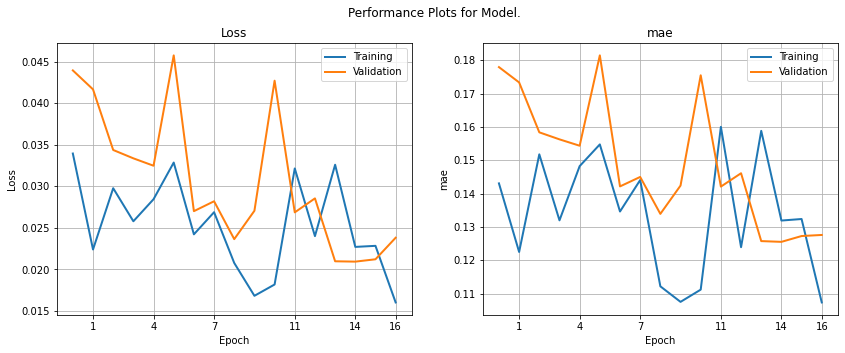

In [ ]:
performance_plot(trained_model01a.history, metrics=['mae'])

In [ ]:
# Inverse Transform of MinMaxScaler expects
# a shape (1, 17), we are going to do that
b = np.zeros((1, 17))
# We set the mean scaled IAQ of the last epoch 
# on the 5th column
b[0,4] = trained_model01a.history["val_mae"][-1]
## 
c = scaler_f.inverse_transform(b)
display(Markdown(f"* Mean Absolute Error in Real Scale of the last Epoch: \
**{c[0, 4]:.4f} IAQ points**."))

* Mean Absolute Error in Real Scale of the last Epoch: **63.2240 IAQ points**.

## Model DNN01

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

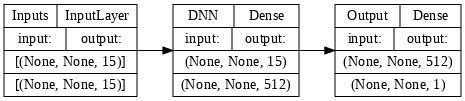

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_dnn01 = Sequential(name="model_dnn01")
model_dnn01.add(Input(shape=(None, X_train.shape[1]), name="Inputs"))
model_dnn01.add(Dense(units=512, name="DNN"))
model_dnn01.add(Dense(units=1, name="Output"))
plot_model(model_dnn01, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="LR", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_dnn01.name)
model_dnn01.save(f"{base_dir}.h5")

In [ ]:
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
dill_path = os.path.join(base_url, "models-paper", 
                       "scaler-iaq.dill")
with io.open(dill_path, 'wb') as dill_file:
  print(f"Saving file: {dill_path}...", end=' ')
  dill.dump(scaler_iaq, dill_file)
  print("Done!")

Saving file: drive/MyDrive/Colab Notebooks/proyecto-final/models-paper/scaler-iaq.dill... Done!


## Model Best 03a

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

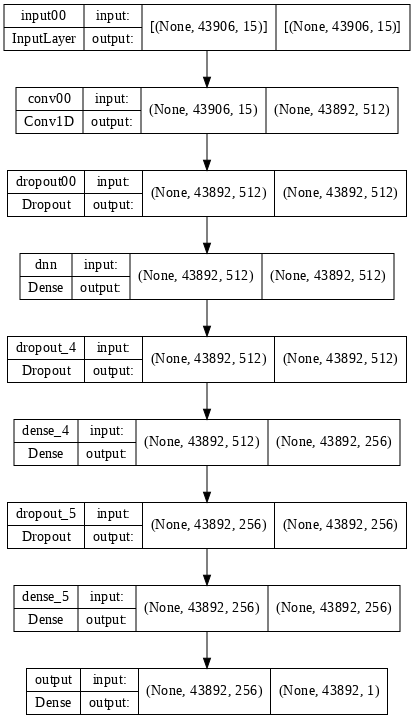

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

model_best03a = Sequential(name="model_best03a")
model_best03a.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_best03a.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_best03a.add(Dropout(0.3, name="dropout00"))
model_best03a.add(Dense(units=512, activation='relu', name="dnn"))
model_best03a.add(Dropout(0.3))
model_best03a.add(Dense(units=256, activation='relu'))
model_best03a.add(Dropout(0.5))
model_best03a.add(Dense(units=256, activation='relu'))
model_best03a.add(Dense(units=1, activation=None, name="output"))
plot_model(model_best03a, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TB", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_best03a.name)
model_best03a.save(f"{base_dir}.h5")

## Model Best 03b

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

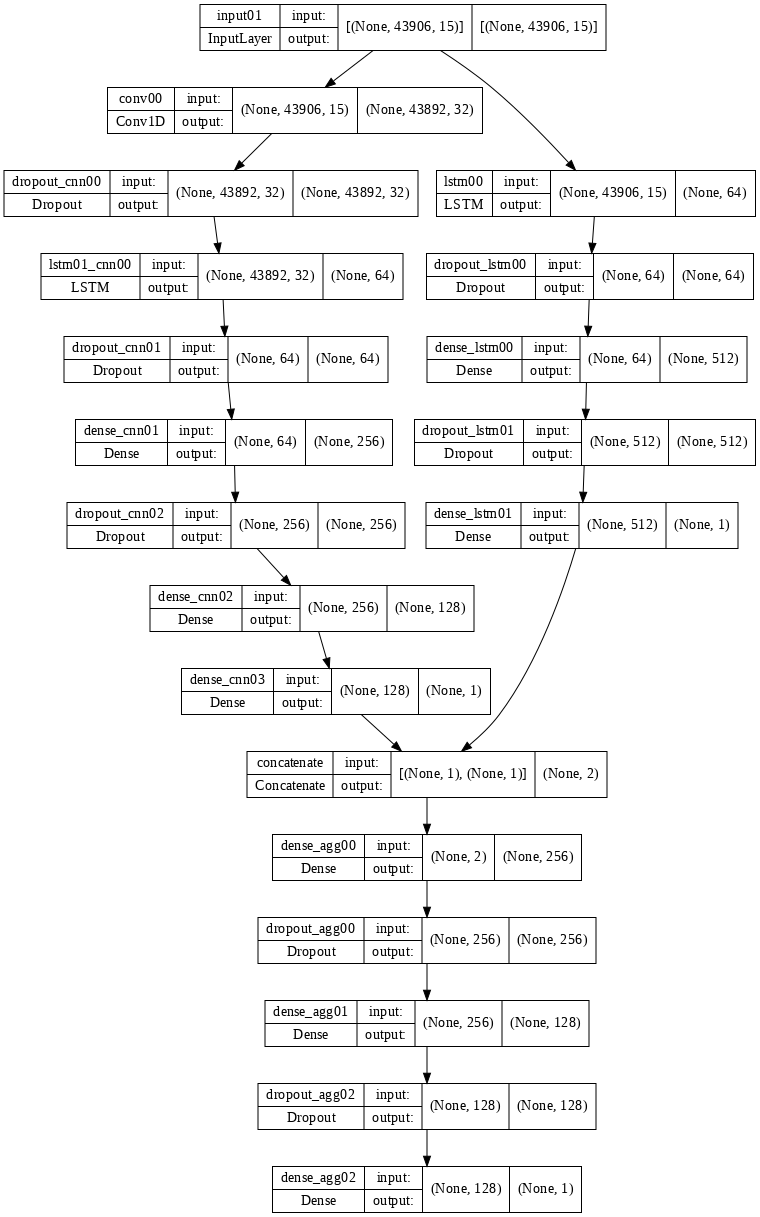

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

# LSTM Section
lstm01 = LSTM(units=64, name="lstm00")(input01)
lstm01 = Dropout(0.2, name="dropout_lstm00")(lstm01)
lstm01 = Dense(512, name="dense_lstm00", activation='relu')(lstm01)
lstm01 = Dropout(0.2, name="dropout_lstm01")(lstm01)
lstm01 = Dense(1, name="dense_lstm01")(lstm01)

# Convolutional Section
conv01 = Conv1D(32, X_train.shape[1], activation='relu', name="conv00")(input01)
conv01 = Dropout(0.5, name="dropout_cnn00")(conv01)
conv01 = LSTM(units=64, name="lstm01_cnn00")(conv01)
conv01 = Dropout(0.5, name="dropout_cnn01")(conv01)
#conv00 = Dense(512, name="dense_cnn00")(conv00)
conv01 = Dense(256, name="dense_cnn01", activation='relu')(conv01)
conv01 = Dropout(0.5, name="dropout_cnn02")(conv01)
conv01 = Dense(128, name="dense_cnn02", activation='relu')(conv01)
#conv00 = tf.keras.layers.Flatten(name="flatten_cnn00")(conv00)
conv01 = Dense(1, name="dense_cnn03")(conv01)

# Merge Layers
concat01 = tf.keras.layers.concatenate([lstm01, conv01])

pred01 = Dense(256, name="dense_agg00")(concat01)
pred01 = Dropout(0.5, name="dropout_agg00")(pred01)
pred01 = Dense(128, name="dense_agg01")(pred01)
pred01 = Dropout(0.5, name="dropout_agg02")(pred01)
pred01 = Dense(1, name="dense_agg02")(pred01)

# Create a Model that tights everythin' together
model_best03b = Model(
    inputs=[input01],
    outputs=[pred01],
    name="model_best03b"
)
plot_model(model_best03b, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_best03b.name)
model_best03b.save(f"{base_dir}.h5")

## Model RNN00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

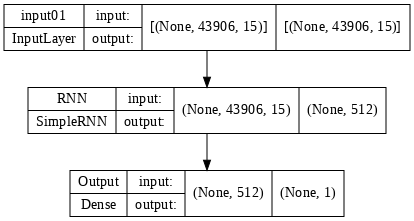

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_rnn00 = Sequential(name="model_rnn00")
model_rnn00.add(input01)
model_rnn00.add(SimpleRNN(units=512, name="RNN"))
model_rnn00.add(Dense(units=1, name="Output"))

plot_model(model_rnn00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_rnn00.name)
model_rnn00.save(f"{base_dir}.h5")

## Model RNN02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

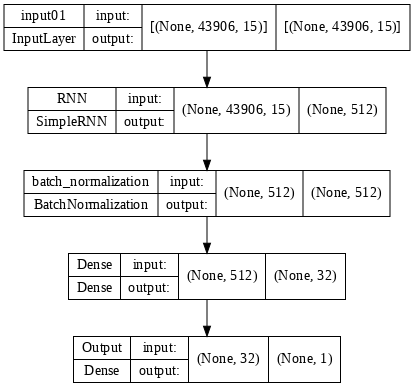

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_rnn02 = Sequential(name="model_rnn02")
model_rnn02.add(input01)
model_rnn02.add(SimpleRNN(units=512, name="RNN"))
model_rnn02.add(tf.keras.layers.BatchNormalization())
model_rnn02.add(Dense(units=32, name="Dense"))
model_rnn02.add(Dense(units=1, name="Output"))

plot_model(model_rnn02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_rnn02.name)
model_rnn02.save(f"{base_dir}.h5")

## Model LSTM00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

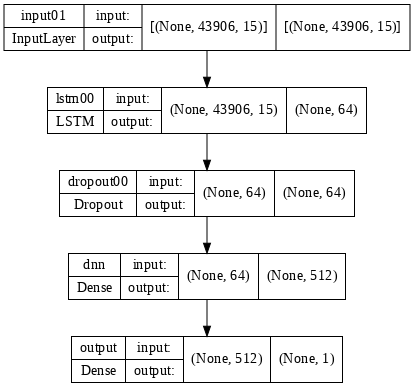

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_lstm00 = Sequential(name="model_lstm00")
model_lstm00.add(input01)
model_lstm00.add(LSTM(units=64, name="lstm00"))
model_lstm00.add(Dropout(0.5, name="dropout00"))
model_lstm00.add(Dense(units=512, activation='relu', name="dnn"))
model_lstm00.add(Dense(units=1, activation=None, name="output"))

plot_model(model_lstm00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_lstm00.name)
model_lstm00.save(f"{base_dir}.h5")

## Model LSTM02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

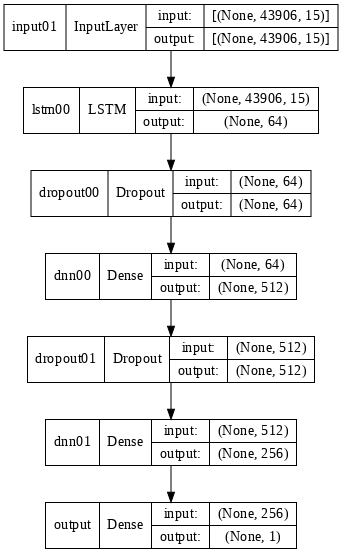

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_lstm02 = Sequential(name="model_lstm02")
model_lstm02.add(input01)
model_lstm02.add(LSTM(units=64, name="lstm00"))
model_lstm02.add(Dropout(0.2, name="dropout00"))
model_lstm02.add(Dense(units=512, activation='relu', name="dnn00"))
model_lstm02.add(Dropout(0.2, name="dropout01"))
model_lstm02.add(Dense(units=256, activation='relu', name="dnn01"))
model_lstm02.add(Dense(units=1, activation=None, name="output"))

plot_model(model_lstm02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_lstm02.name)
model_lstm02.save(f"{base_dir}.h5")

## Model Conv00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

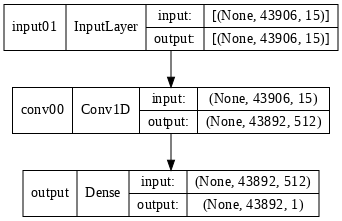

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_conv00 = Sequential(name="model_conv00")
model_conv00.add(input01)
model_conv00.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_conv00.add(Dense(units=1, activation=None, name="output"))

plot_model(model_conv00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_conv00.name)
model_conv00.save(f"{base_dir}.h5")

## Model Conv02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

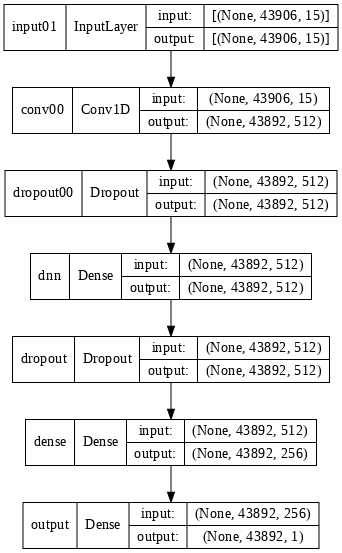

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_conv02 = Sequential(name="model_conv02")
model_conv02.add(input01)
model_conv02.add(Conv1D(512, X_train.shape[1], activation='relu', name="conv00"))
model_conv02.add(Dropout(0.5, name="dropout00"))
model_conv02.add(Dense(units=512, activation='relu', name="dnn"))
model_conv02.add(Dropout(0.5))
model_conv02.add(Dense(units=256, activation='relu'))
model_conv02.add(Dense(units=1, activation=None, name="output"))

plot_model(model_conv02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_conv02.name)
model_conv02.save(f"{base_dir}.h5")

## Model DNN00

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

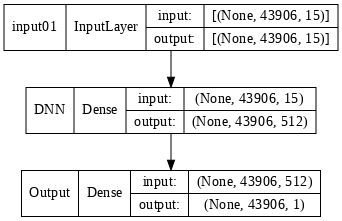

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_dnn00 = Sequential(name="model_dnn00")
model_dnn00.add(input01)
model_dnn00.add(Dense(units=512, name="DNN"))
model_dnn00.add(Dense(units=1, name="Output"))

plot_model(model_dnn00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_dnn00.name)
model_dnn00.save(f"{base_dir}.h5")

## Model DNN02

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

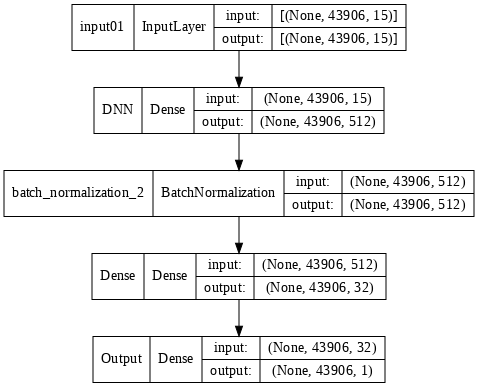

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_dnn02 = Sequential(name="model_dnn02")
model_dnn02.add(input01)
model_dnn02.add(Dense(units=512, name="DNN"))
model_dnn02.add(tf.keras.layers.BatchNormalization())
model_dnn02.add(Dense(units=32, name="Dense"))
model_dnn02.add(Dense(units=1, name="Output"))

plot_model(model_dnn02, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_dnn02.name)
model_dnn02.save(f"{base_dir}.h5")

## Model Baseline

Time series parameters:

```timeseries_dataset_from_array(  sequence_length=576,  sampling_rate=1,  batch_size=256,  seed=175904)```

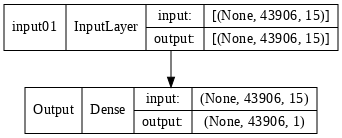

In [ ]:
# Data Prep
WINDOW_SIZE_DAYS = 2
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(data[[x 
                                        for x in data.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (data.index[-1] - data.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
display(Markdown("Time series parameters:"))
display(Markdown(f"```timeseries_dataset_from_array(\
  sequence_length={past},\
  sampling_rate={sampling_rate},\
  batch_size={BATCH_SIZE},\
  seed=175904)```"))

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), name="input01")  

model_baseline00 = Sequential(name="model_baseline00")
model_baseline00.add(input01)
model_baseline00.add(Dense(units=1, name="Output", activation=None))
#plot_model(model_baseline00, to_file=os.path.join(base_url, "data/model.png"), 
#           dpi=72, rankdir="LR", show_shapes=True, expand_nested=True)

plot_model(model_baseline00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", model_baseline00.name)
model_baseline00.save(f"{base_dir}.h5")

## Fixing 6 Weeks Models

We found that the validation didn't run for some reason on our models when having a history of 6 weeks.

Reading the models:

In [ ]:
model_path = os.path.join(base_url, 
                 "output--hyper10min-b64-w45-stride1-samplingrate2")
models = []
for model_file in os.listdir(model_path):
  print(f"Loading file model_file {model_file}...", end=" ")
  models.append(tf.keras.models.load_model(
      os.path.join(model_path, model_file)
  ))
  print("Done!")

Loading file model_file model_lstm00.h5... Done!
Loading file model_file model_conv00.h5... Done!
Loading file model_file model_dnn00.h5... Done!
Loading file model_file model_conv02.h5... Done!
Loading file model_file model_best01a.h5... Done!


We set the data source in order to get the:

* True $y$'s.

* Get the validation $x$'s to predict the $\hat{y}$.

In [ ]:
df = pd.read_pickle("https://github.com/philwebsurfer/dlfinal/raw/main/data/data_10min.pickle.gz",
                    compression='gzip')

# Data Prep
WINDOW_SIZE_DAYS = 45
stride = 1
excluded_columns = ["iaqAccuracy", "wind_speed", "wind_deg"]
train, test = train_test_split(df[[x 
                                        for x in df.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.7, random_state=175904, shuffle=False)
# Scaling
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]

# sampling_rate: 3 seconds per sample
##sampling_rate = 3
sampling_rate = 1
# 1 hours * minutes * seconds / sampling_rate in seconds
##past = int(1 * 60 * 60 / sampling_rate) 
timedelta_minutes = (df.index[-1] - df.index[-2]).seconds//60
past = int(WINDOW_SIZE_DAYS) * 24 * 60 // timedelta_minutes
#display(f"X_train shape = {X_train.shape}")
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test[:, 1],
  sequence_length=past,
  sampling_rate=sampling_rate,
  sequence_stride=stride,
  batch_size=BATCH_SIZE,
  seed=175904
)

In [ ]:
past

6480

We proceed to get the predict the $\hat{y}$:

In [ ]:
%%time
y_hats = {}
for model in models:
  print(f"Predicting the y hats for model \"{model.name}\"...", end=" ")
  y_hats[model.name] = model.predict(test3_iaq)
  print("Done!")

Predicting the y hats for model "model_lstm00"... Done!
Predicting the y hats for model "model_conv00"... Done!
Predicting the y hats for model "model_dnn00"... Done!
Predicting the y hats for model "model_conv02"... Done!
Predicting the y hats for model "model_best01a"... Done!
CPU times: user 22.7 s, sys: 4.25 s, total: 27 s
Wall time: 44.5 s


In [ ]:
y_hats.keys()

dict_keys(['model_lstm00', 'model_conv00', 'model_dnn00', 'model_conv02', 'model_best01a'])

In [ ]:
len(y_hats["model_best01a"])

2931

In [ ]:
len(Y_test)

9410

In [ ]:
y_hats["model_best01a"][-2]

array([[0.40914166],
       [0.40914166],
       [0.40914166],
       ...,
       [0.40914184],
       [0.40914187],
       [0.40914184]], dtype=float32)

In [ ]:
len(Y_test[past-1:, 1])

2931

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(Y_test[past-1:, 1], y_hats["model_best01a"][:, 0, 0])

0.030596263103119924

In [ ]:
for model in y_hats.keys():
  y_hat = y_hats[model]
  print(f"Shape of {model}: {y_hat.shape}")
  if len(y_hat.shape) > 2:
    print(f" Shape of {model}: {y_hat[:,:, 0].mean(axis=1).shape}")
    print(f"  mse={mean_squared_error(Y_test[past-1:, 1], y_hat[:, :, 0].mean(axis=1))}")
    print(f"  mae={mean_absolute_error(Y_test[past-1:, 1], y_hat[:, :, 0].mean(axis=1))}")
  else:
    print(f" Shape of {model}: {y_hat[:, 0].shape}")
    print(f"  mse={mean_squared_error(Y_test[past-1:, 1], y_hat[:, 0])}")
    print(f"  mae={mean_absolute_error(Y_test[past-1:, 1], y_hat[:, 0])}")

Shape of model_lstm00: (2931, 1)
 Shape of model_lstm00: (2931,)
  mse=0.028633685371812847
  mae=0.14440499236337684
Shape of model_conv00: (2931, 6466, 1)
 Shape of model_conv00: (2931,)
  mse=0.10565433191409049
  mae=0.28295468567733634
Shape of model_dnn00: (2931, 6480, 1)
 Shape of model_dnn00: (2931,)
  mse=0.05798647852976501
  mae=0.2012153250123069
Shape of model_conv02: (2931, 6466, 1)
 Shape of model_conv02: (2931,)
  mse=0.026132470975462244
  mae=0.13538214853361374
Shape of model_best01a: (2931, 6466, 1)
 Shape of model_best01a: (2931,)
  mse=0.030596268615801434
  mae=0.14814169067075755


In [ ]:
mean_squared_error(Y_test[past-1:, 1], y_hats["model_best01a"][:, :, 0].mean(axis=1))

0.030596268615801434

In [ ]:
y_hats["model_best01a"].shape

(2931, 6466, 1)

In [ ]:
y_hat = y_hats["model_best01a"]
y_hat[:, :, 0].mean(axis=1).shape

(2931,)

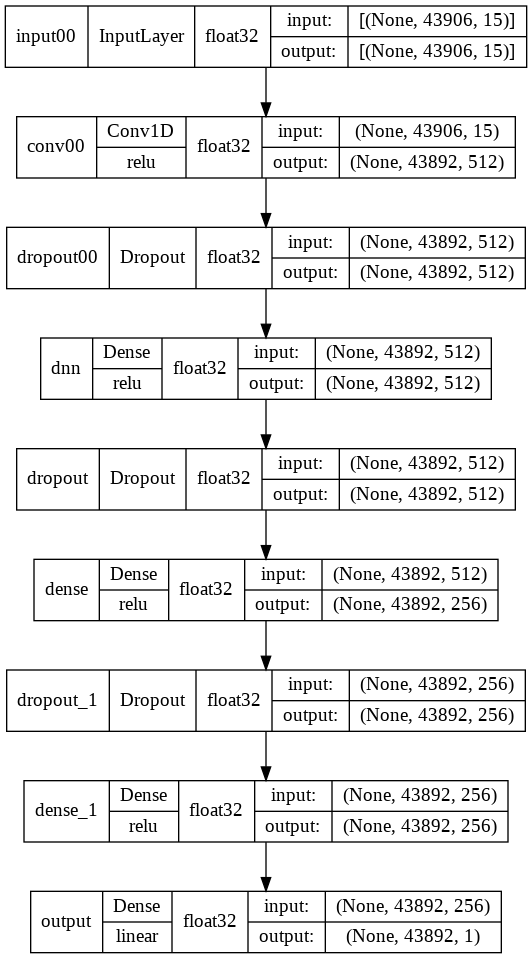

In [ ]:
plot_model(models[-1], to_file='model.png', expand_nested=True, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [ ]:
models["model_best01a"]

TypeError: ignored

In [ ]:
np.mean(y_hats["model_best01a"])

## Model ParNet0

#### Downsampling

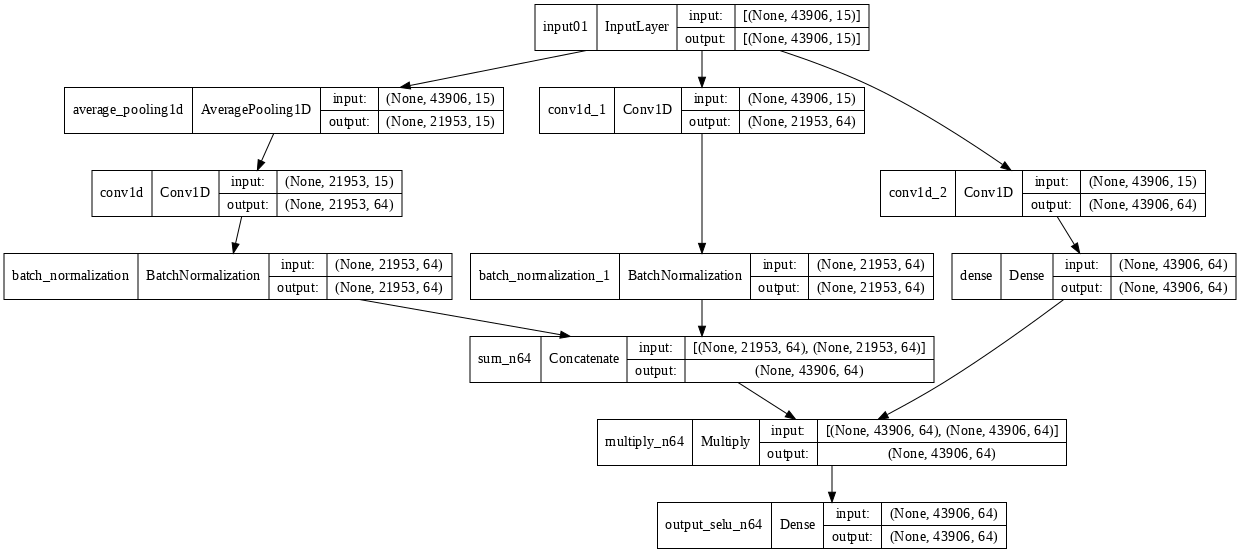

In [ ]:
def DownSampling(input01, n=64, groups=1, debug=False):
  avgpool2x2 = tf.keras.layers.AveragePooling1D(2)(input01)
  avgpool2x2 = Conv1D(n, 1, groups=groups)(avgpool2x2)
  avgpool2x2 = BatchNormalization()(avgpool2x2)

  if debug: print("here 0")
  conv3x3 = Conv1D(n, 2, strides=2, groups=groups)(input01)
  conv3x3 = BatchNormalization()(conv3x3)

  if debug: print("here 1")
  agg01 = tf.keras.layers.Concatenate(axis=1, name="sum_n%02d"%n)(
      [avgpool2x2, conv3x3])

  #gavgpool1x1 = GlobalAveragePooling1D()(input01)
  gavgpool1x1 = tf.keras.layers.Conv1D(n, 1, groups=groups)(input01)
  gavgpool1x1 = Dense(agg01.shape[2], 
                      activation='sigmoid')(gavgpool1x1)

  if debug: print("here 2")
  if debug: print("agg01 shape: %s"%agg01.shape)
  if debug: print("gavgpool1x2 shape: %s"%gavgpool1x1.shape)
  prd01 = tf.keras.layers.Multiply(name="multiply_n%02d"%n)([agg01, gavgpool1x1])
  prd01 = Dense(n, activation="selu", name="output_selu_n%02d"%n)(prd01)

  if debug: print("here 3")
  downsampling01 = Model([input01], [prd01],
                         name="%s_%02d.%02d"%(
                             "downsampling" if groups==1 else "fusion",
                             n, 
                             np.random.randint(0, 99))
                         )
  
  if debug: print("here 4")
  return downsampling01

input01 = Input(shape=(X_train.shape[0], X_train.shape[1],), 
                name="input01")
downsampling01 = DownSampling(input01, 64)
plot_model(downsampling01, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

#### SSE

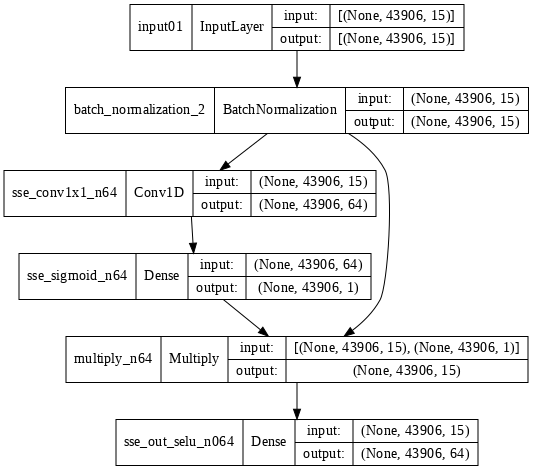

In [ ]:
def SSE(input01, n=64, groups=1, debug=False):
  #gavg01 = GlobalAveragePooling1D(name="sse_globalavg_n%02d"%n)(input01)
  sse_bn = BatchNormalization()(input01)
  gavg01 = Conv1D(n, 1, groups=groups, name="sse_conv1x1_n%02d"%n)(sse_bn)
  gavg01 = Dense(1, name="sse_sigmoid_n%02d"%n)(gavg01)

  sse_bn = tf.keras.layers.Multiply(name="multiply_n%02d"%n)([sse_bn, gavg01])
  sse_bn = Dense(n, activation="selu", name="sse_out_selu_n0%02d"%n)(sse_bn)

  sse = Model([input01], [sse_bn], name="sse_n%02d"%(n))
  return sse

sse = SSE(input01, 64)
plot_model(sse, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=False)

#### Stream

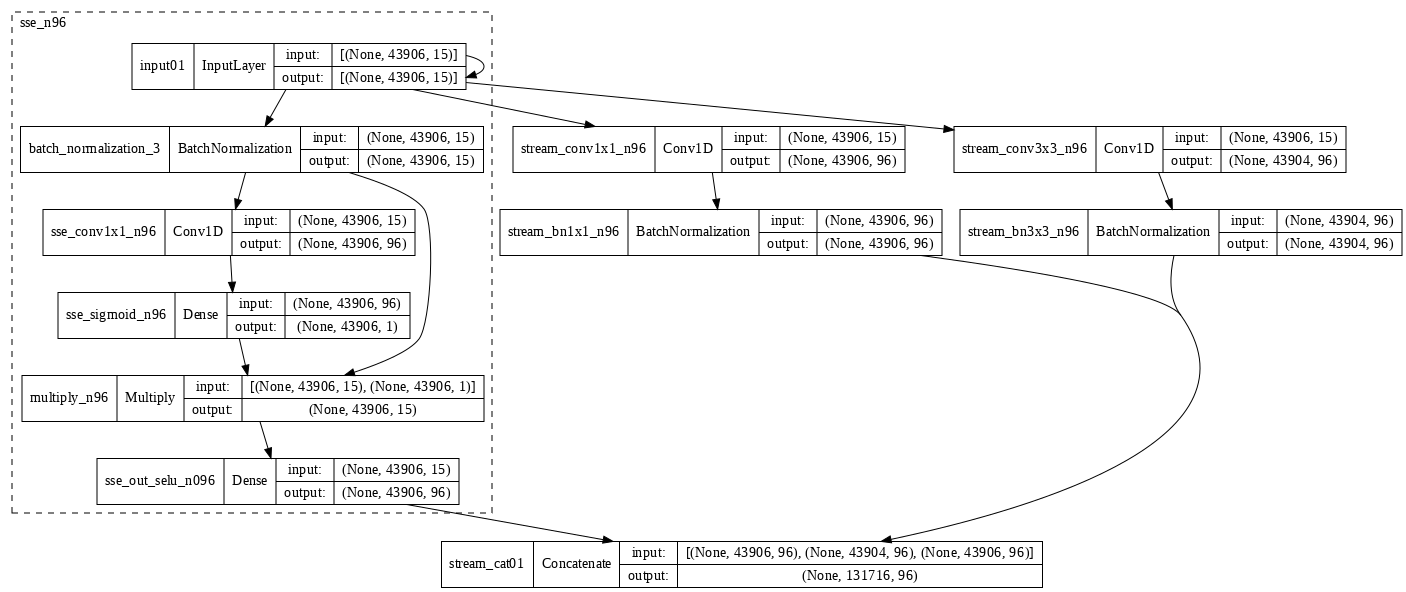

In [ ]:
def Stream(input01, n=96, groups=1, debug=False):
  conv1x1 = Conv1D(n, 1, groups=groups, name='stream_conv1x1_n%02d'%n)(input01)
  conv1x1 = BatchNormalization(name='stream_bn1x1_n%02d'%n)(conv1x1)

  conv3x3 = Conv1D(n, 3, groups=groups, name='stream_conv3x3_n%02d'%n)(input01)
  conv3x3 = BatchNormalization(name='stream_bn3x3_n%02d'%n)(conv3x3)

  sse = SSE(input01, n=n, groups=groups)(input01)

  cat01 = tf.keras.layers.Concatenate(axis=1, name="stream_cat01")(
      [conv1x1, conv3x3, sse])

  stream01 = Model([input01], [cat01], name="stream_n%02d.%03d"%(
      n, np.random.randint(0, 999)))
  return stream01

stream01 = Stream(input01, n=96)
plot_model(stream01, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

#### Sequence

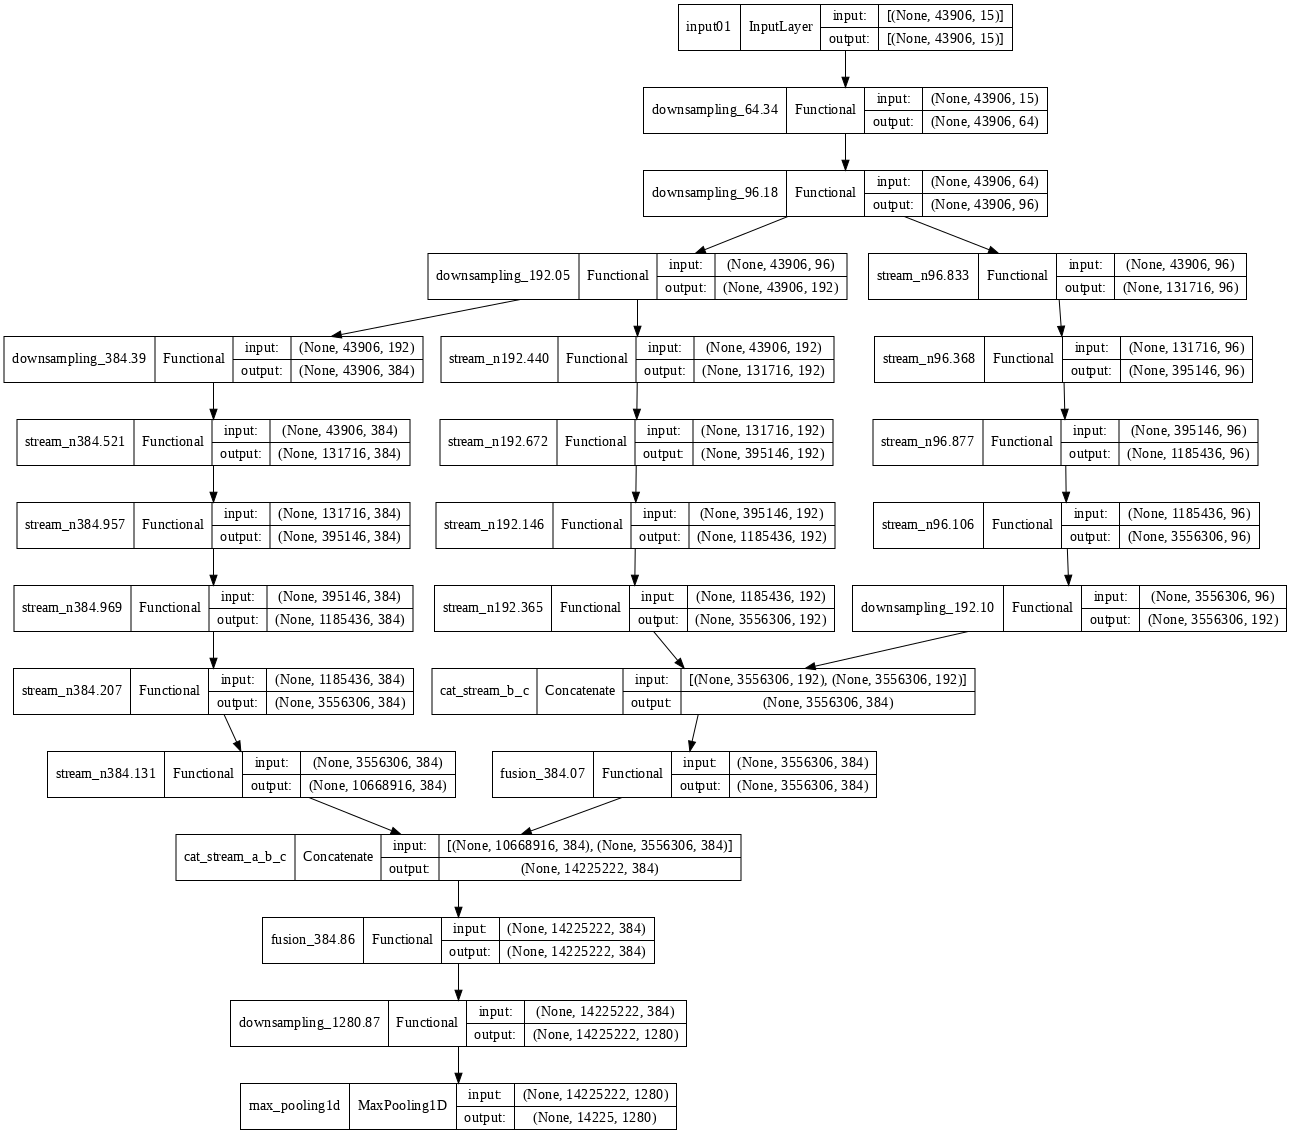

In [ ]:
factor = 1

if (64 // factor) <= 0:
  raise Exception("Factor cannot be greater than 64!!!")

downsampler = DownSampling(input01, 64//factor)(input01)
downsampler = DownSampling(downsampler, 96//factor)(downsampler)

str_c = Stream(downsampler, n=96//factor)(downsampler)
str_c = Stream(str_c, n=96//factor)(str_c)
str_c = Stream(str_c, n=96//factor)(str_c)
str_c = Stream(str_c, n=96//factor)(str_c)
str_c = DownSampling(str_c, n=192//factor)(str_c)

downsampler = DownSampling(downsampler, 192)(downsampler)

str_b = Stream(downsampler, n=192//factor)(downsampler)
str_b = Stream(str_b, n=192//factor)(str_b)
str_b = Stream(str_b, n=192//factor)(str_b)
str_b = Stream(str_b, n=192//factor)(str_b)

cat_str_bc = tf.keras.layers.Concatenate(axis=2, name="cat_stream_b_c")(
      [str_b, str_c])
cat_str_bc = DownSampling(cat_str_bc, n=384//factor, groups=2)(cat_str_bc)

downsampler = DownSampling(downsampler, 384//factor)(downsampler)
downsampler = Stream(downsampler, n=384//factor)(downsampler)
downsampler = Stream(downsampler, n=384//factor)(downsampler)
downsampler = Stream(downsampler, n=384//factor)(downsampler)
downsampler = Stream(downsampler, n=384//factor)(downsampler)
downsampler = Stream(downsampler, n=384//factor)(downsampler)

cat_str_abc = tf.keras.layers.Concatenate(axis=1, name="cat_stream_a_b_c")(
      [downsampler, cat_str_bc])
cat_str_abc = DownSampling(cat_str_abc, n=384//factor, groups=2)(cat_str_abc)
cat_str_abc = DownSampling(cat_str_abc, n=1280//factor)(cat_str_abc)
cat_str_abc = tf.keras.layers.MaxPooling1D(1000//factor)(cat_str_abc)

parnet00 = Model([input01], [cat_str_abc], name="ParNet00")
plot_model(parnet00, to_file=os.path.join(base_url, "model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=False)

In [ ]:
base_dir = os.path.join(base_url, "models-paper", parnet00.name)
parnet00.save(f"{base_dir}.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### Job Training

In [ ]:
BATCH_SIZE

256

In [ ]:
cbk = TqdmCallback()
tiempo = time.time()
parnet00.compile(optimizer='adam', loss='mse')
history = parnet00.fit(train3_iaq, validation_data=test3_iaq,
                    epochs=5, steps_per_epoch=2, 
                    batch_size=8, callbacks=[cbk])
clear_output()
tiempo = time.time() - tiempo
print(f"Processing Time: {tiempo:.2f} seconds.")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5


In [ ]:
trained_parnet00 = train_model(parnet00, train3_iaq,
                            validation_data=test3_iaq,
                            metrics=["mse", "mae"],
                            epochs=5, steps_per_epoch=2, 
                            batch_size=BATCH_SIZE, base_dir=base_url)                          

InvocationException: ignored

In [ ]:
performance_plot(trained_parnet00.history, metrics=['mae', "mae"])